In [9]:
import pandas as pd
import sys
sys.path.append('../supercenter-product-recommender')  # Adjust the path as necessary
from db_utilities import read_table
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

In [10]:
df = read_table('processed_orders_data')
df.head()

,row_id,order_id,product_id,cart_inclusion_order,reordered,product_name,aisle_id,department_id,department,aisle
0,0,1,49302,1,1,EL YOGUR DE BULGARIA,120,16,HUEVOS Y LÁCTEOS,YOGUR
1,1,1,11109,2,1,4% ORGÁNICO QUESO GRASA DE LECHE LECHE ENTERA ...,108,16,HUEVOS Y LÁCTEOS,OTROS QUESOS CREMAS
2,2,1,10246,3,0,CORAZONES DE APIO ORGÁNICOS,83,4,FRUTAS Y VERDURAS,VEGETALES FRESCOS
3,3,1,49683,4,0,KIRBY PEPINO,83,4,FRUTAS Y VERDURAS,VEGETALES FRESCOS
4,4,1,43633,5,1,LAS SARDINAS LIGERAMENTE AHUMADO EN ACEITE DE ...,95,15,PRODUCTOS ENLATADOS,MARISCOS CARNE ENLATADA


# Product Level Association Analysis

In [4]:
sample_size = 10000  # Change this to the desired sample size

# Get a unique list of order_ids
unique_orders = df['order_id'].unique()

# Randomly sample order_ids
sampled_orders = pd.Series(unique_orders).sample(n=sample_size, random_state=42).values

# Step 2: Filter the DataFrame to include only the rows with the selected order_ids
subsampled_data = df[df['order_id'].isin(sampled_orders)]

In [5]:
basket = (subsampled_data\
          .groupby(['order_id', 'product_name'])['product_name']\
          .count().unstack().reset_index().fillna(0)\
          .set_index('order_id'))

# Convert values to binary
basket = basket.map(lambda x: 1 if x > 0 else 0)

# Check the basket matrix
print(f"Basket shape: {basket.shape}")
print(f"Total number of item occurrences: {basket.sum().sum()}")

KeyboardInterrupt: 

In [11]:
# Apply Apriori Algorithm with a lower minimum support
frequent_itemsets = apriori(basket, min_support=0.005, use_colnames=True)

# Generate Association Rules with a minimum threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the resulting rules
print(f"Number of rules generated: {len(rules)}")
print(rules.head())

/Users/diegoleon/Documents/DLR/Madrid/IE/3rd Term/Capstone Project/supercenter-product-recommender/venv/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Number of rules generated: 230
                  antecedents                 consequents  antecedent support  \
0  (100% PAN DE TRIGO ENTERO)                    (BANANA)            0.017210   
1                    (BANANA)  (100% PAN DE TRIGO ENTERO)            0.144587   
2         (AGUACATE ORGÁNICO)              (AJO ORGÁNICO)            0.052732   
3              (AJO ORGÁNICO)         (AGUACATE ORGÁNICO)            0.035221   
4         (AGUACATE ORGÁNICO)                    (BANANA)            0.052732   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.144587  0.005303    0.308140  2.131174  0.002815    1.236396   
1            0.017210  0.005303    0.036678  2.131174  0.002815    1.020209   
2            0.035221  0.005403    0.102467  2.909242  0.003546    1.074923   
3            0.052732  0.005403    0.153409  2.909242  0.003546    1.118921   
4            0.144587  0.017310    0.328273  2.270424  0.009686    1.273454   

   zhan

# Aisle Level Association Analysis

In [13]:
basket = (df\
          .groupby(['order_id', 'aisle_id'])['aisle_id']\
          .count().unstack().reset_index().fillna(0)\
          .set_index('order_id'))

# Convert values to binary
basket = basket.map(lambda x: 1 if x > 0 else 0).astype(bool)

# Check the basket matrix
print(f"Basket shape: {basket.shape}")
print(f"Total number of item occurrences: {basket.sum().sum()}")

Basket shape: (131209, 135)
Total number of item occurrences: 998645


In [14]:
# Apply Apriori Algorithm with a lower minimum support
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate Association Rules with a minimum threshold
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the resulting rules
print(f"Number of rules generated: {len(rules)}")

Number of rules generated: 28308


In [20]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(1),(24),0.019900,0.539468,0.012331,0.619686,1.148699,0.001596,1.210927,0.132078
1,(24),(1),0.539468,0.019900,0.012331,0.022859,1.148699,0.001596,1.003028,0.281088
2,(1),(83),0.019900,0.450541,0.010022,0.503638,1.117853,0.001057,1.106974,0.107569
3,(83),(1),0.450541,0.019900,0.010022,0.022245,1.117853,0.001057,1.002399,0.191876
4,(100),(107),0.052679,0.174325,0.012156,0.230758,1.323724,0.002973,1.073362,0.258155
...,...,...,...,...,...,...,...,...,...,...
28303,(24),"(120, 83, 86, 123, 84)",0.539468,0.011303,0.010358,0.019200,1.698685,0.004260,1.008052,0.893117
28304,(83),"(120, 24, 86, 123, 84)",0.450541,0.012987,0.010358,0.022989,1.770173,0.004506,1.010238,0.791840
28305,(86),"(120, 24, 83, 123, 84)",0.147048,0.033367,0.010358,0.070436,2.110985,0.005451,1.039879,0.617019
28306,(123),"(120, 24, 83, 86, 84)",0.382039,0.013810,0.010358,0.027111,1.963149,0.005082,1.013672,0.793925


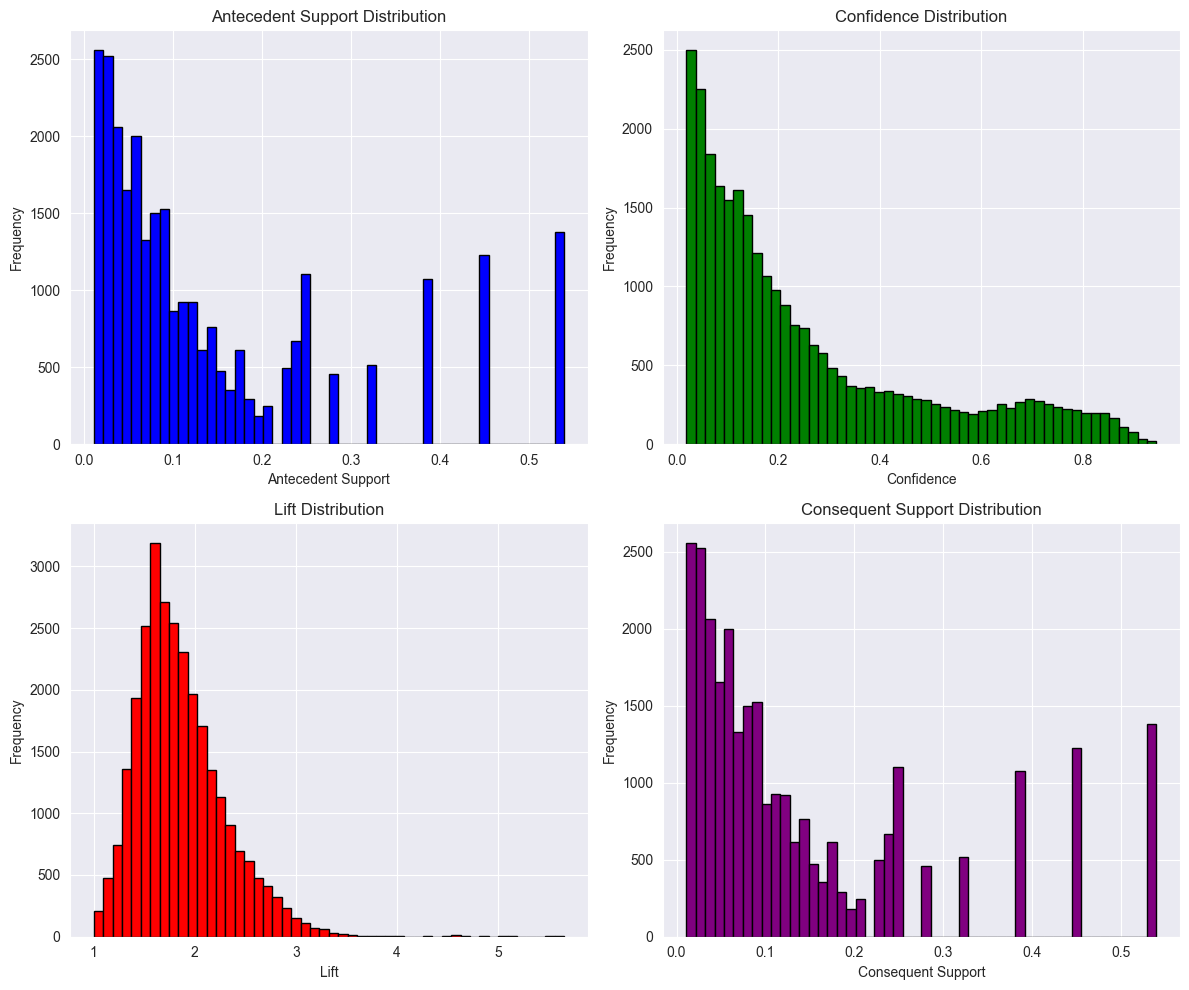

In [24]:
import matplotlib.pyplot as plt

# Plot distributions of support, confidence, lift, and consequent support
plt.figure(figsize=(12, 10))

# Plot Antecedent Support Distribution
plt.subplot(2, 2, 1)
plt.hist(rules['antecedent support'], bins=50, color='blue', edgecolor='black')
plt.title('Antecedent Support Distribution')
plt.xlabel('Antecedent Support')
plt.ylabel('Frequency')

# Plot Confidence Distribution
plt.subplot(2, 2, 2)
plt.hist(rules['confidence'], bins=50, color='green', edgecolor='black')
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

# Plot Lift Distribution
plt.subplot(2, 2, 3)
plt.hist(rules['lift'], bins=50, color='red', edgecolor='black')
plt.title('Lift Distribution')
plt.xlabel('Lift')
plt.ylabel('Frequency')

# Plot Consequent Support Distribution
plt.subplot(2, 2, 4)
plt.hist(rules['consequent support'], bins=50, color='purple', edgecolor='black')
plt.title('Consequent Support Distribution')
plt.xlabel('Consequent Support')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()